In [2]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

### 相關係數
一樣，pandas 很貼心地讓我們可以非常容易計算相關係數

In [4]:
corr_df = app_train.corr()

In [12]:
corr_df['TARGET']['EXT_SOURCE_3']
corr_df['TARGET']

SK_ID_CURR                                 -0.002108
TARGET                                      1.000000
NAME_CONTRACT_TYPE                         -0.030896
FLAG_OWN_CAR                               -0.021851
FLAG_OWN_REALTY                            -0.006148
CNT_CHILDREN                                0.019187
AMT_INCOME_TOTAL                           -0.003982
AMT_CREDIT                                 -0.030369
AMT_ANNUITY                                -0.012817
AMT_GOODS_PRICE                            -0.039645
REGION_POPULATION_RELATIVE                 -0.037227
DAYS_BIRTH                                 -0.078239
DAYS_EMPLOYED                               0.074958
DAYS_REGISTRATION                           0.041975
DAYS_ID_PUBLISH                             0.051457
OWN_CAR_AGE                                 0.037612
FLAG_MOBIL                                  0.000534
FLAG_EMP_PHONE                              0.045982
FLAG_WORK_PHONE                             0.

## 練習時間
列出目標 (TARGET) 與所有欄位之間相關係數，數值最大以及最小各 15 個

通過相關係數的結果觀察有興趣的欄位與 TARGET 或其他欄位的相關係數，並嘗試找出有趣的訊息
- 最好的方式當然是畫圖，舉例來說，我們知道  EXT_SOURCE_3 這個欄位和 TARGET 之間的相關係數是 -0.178919 (在已經這個資料集已經是最負的了！)，那我們可以 EXT_SOURCE_3  為 x 軸， TARGET 為 y 軸，把資料給畫出來

與TARGET 最有相關的是 DAYS_EMPLOYED
可以大致看出通常工作越少年，通常TARGET為0
TARGET                         1.000000
DAYS_EMPLOYED                  0.074958
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
NAME_INCOME_TYPE_Working       0.057481
Name: TARGET, dtype: float64


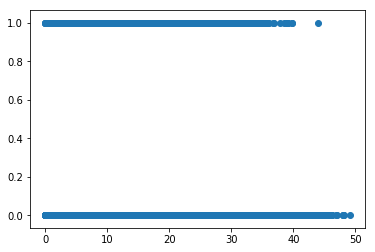

In [17]:
top_corr = corr_df['TARGET'].sort_values(ascending=False).head(15)
last_corr = corr_df['TARGET'].sort_values(ascending=True).head(15)
print("與TARGET 最有相關的是 %s"%top_corr.index[1])
plt.scatter(app_train[top_corr.index[1]]/(-365), app_train['TARGET'])
print("可以大致看出通常工作越少年，通常TARGET為0")
print(top_corr.head(5))

In [103]:
app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED']/(-365)

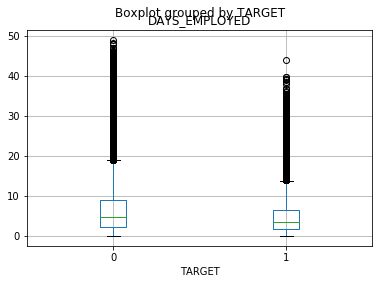

In [104]:
app_train.boxplot('DAYS_EMPLOYED', by='TARGET')

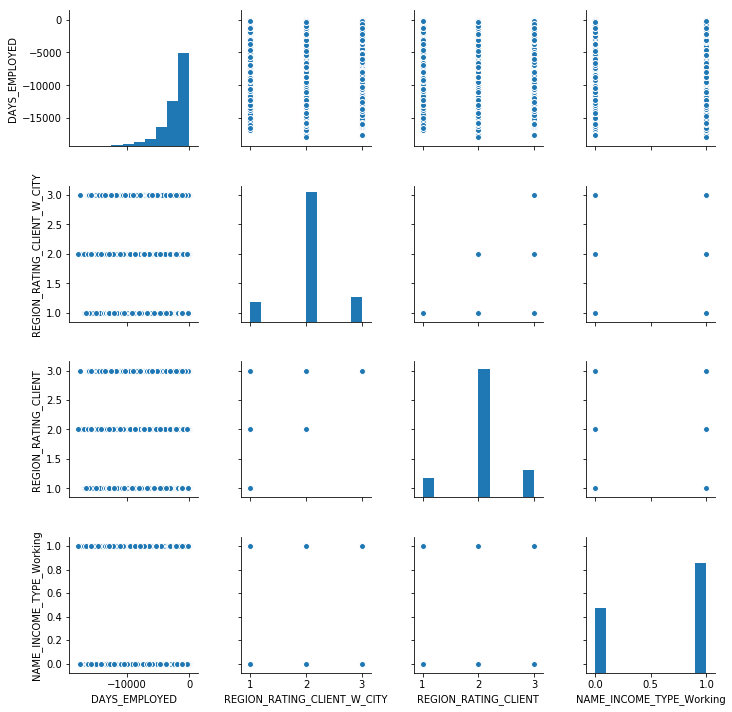

In [30]:
#取相關數最大的前五個欄位來做配對相關性的觀察
import seaborn as sns
# 如果沒有dropna會有error message
sns.pairplot(data=app_train[top_corr[1:5].index].dropna());


與 收入 最有相關的是 AMT_ANNUITY
AMT_INCOME_TOTAL    1.000000
AMT_ANNUITY         0.191657
AMT_GOODS_PRICE     0.159610
AMT_CREDIT          0.156870
FLOORSMIN_AVG       0.139860
Name: AMT_INCOME_TOTAL, dtype: float64


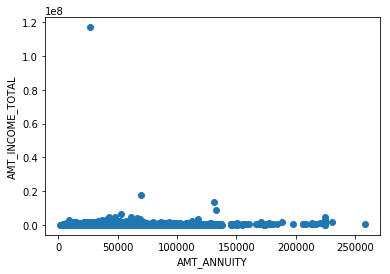

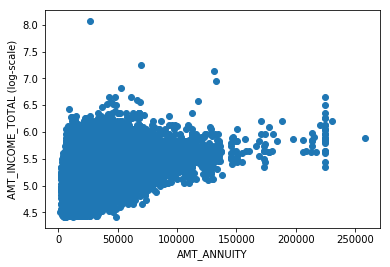

In [32]:
#因為 TARGET 是 0,1 的類別型資料，所以觀察相關係數並無特別意義，故選擇 AMT_INCOME_TOTAL客戶總收入來看相關性
#客戶年收入與車齡的相關性
top_corr = corr_df['AMT_INCOME_TOTAL'].sort_values(ascending=False).head(15)
last_corr = corr_df['AMT_INCOME_TOTAL'].sort_values(ascending=True).head(15)
print("與 收入 最有相關的是 %s"%top_corr.index[1])
print(top_corr.head(5))

plt.xlabel('AMT_ANNUITY')
plt.ylabel('AMT_INCOME_TOTAL')
plt.scatter(abs(app_train['AMT_ANNUITY']) , app_train['AMT_INCOME_TOTAL'])
plt.show()

plt.xlabel('AMT_ANNUITY')
plt.ylabel('AMT_INCOME_TOTAL (log-scale)')
plt.scatter(app_train['AMT_ANNUITY'] , np.log10(app_train['AMT_INCOME_TOTAL']))
plt.show()

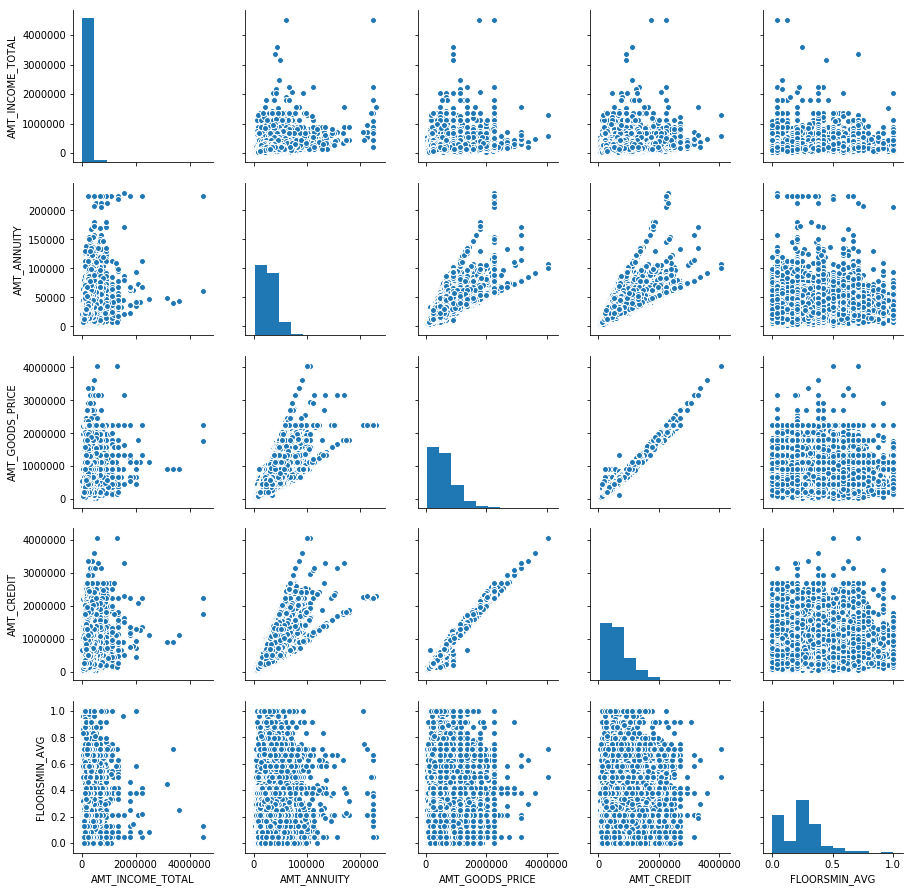

In [34]:
#取相關數最大的前五個欄位來做配對相關性的觀察
import seaborn as sns
# 如果沒有dropna會有error message
sns.pairplot(data=app_train[top_corr[0:5].index].dropna());

# 取 TARGET 最大關聯和最小關聯 總體來看

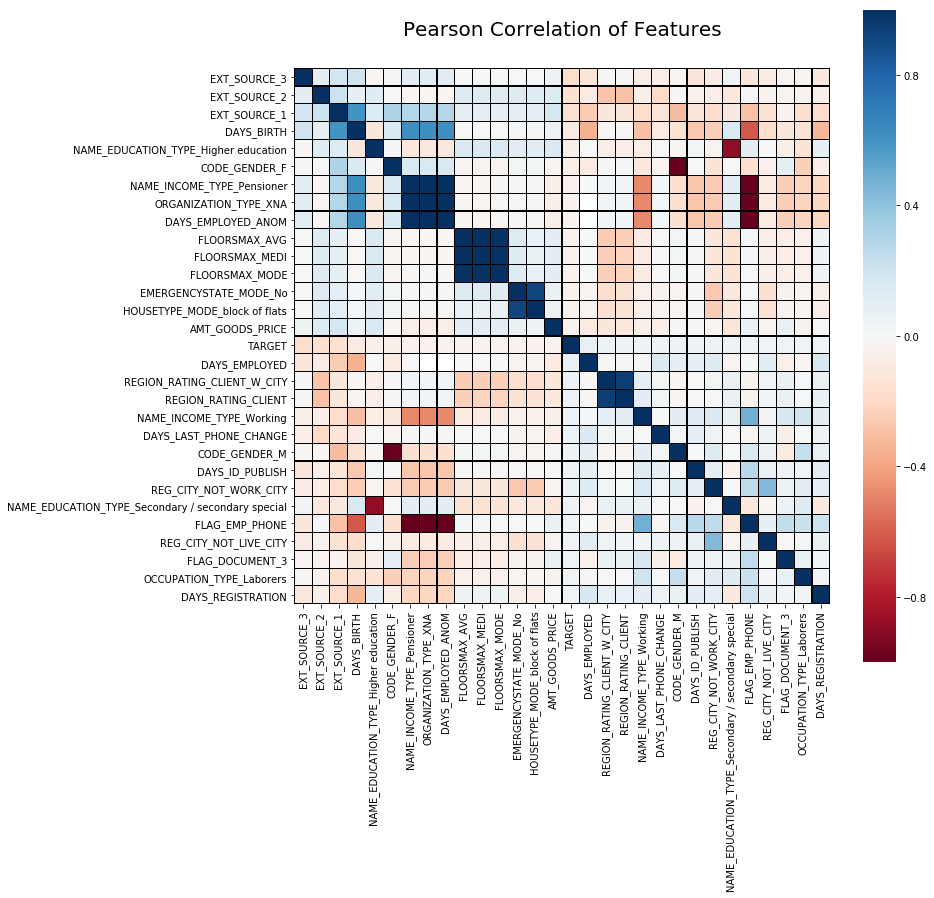

In [47]:
total_col = []
total_col.extend(list(last_corr.index))
total_col.extend(list(top_corr.index))

import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(app_train[total_col]
            .astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='black')
plt.show()